In [1]:
# from circuit_suite import circuits
# # from backend_suite import backends, large_backends, shuffle_test, routing_test
# #from backend_suite import placement_test

In [2]:
# from backend_suite import backends
# backends["Hatlab-Large-Riswap-Dense"].pass_manager.run(circuits["QFT"].circuit_lambda(4))

## Circuit Transpile Benchmark

In [2]:
#make a plot :)
import matplotlib.pyplot as plt

def benchmark(backends, circuit_generator, q_range=None, continuously_save=False, overwrite=False):
    #override qrange if provided
    if q_range is None:
        q_range = circuit_generator.q_range
    
    #check if data dicts are empty
    for backend in backends:
        if not circuit_generator.label in backend.data.keys():
            backend.data[circuit_generator.label] = {}
            backend.data[circuit_generator.label]["duration"] = {}
            backend.data[circuit_generator.label]["preswap_gate_count"] = {}
            backend.data[circuit_generator.label]["preswap_gate_count_crit"] = {}
            backend.data[circuit_generator.label]["layout_score"] = {}
            backend.data[circuit_generator.label]["edge_frequency"] = {}

    #outer loop over circuit since this may take long time to generate
    for q in q_range:
        #create new variable sized lambda circuit

        #wait to build circuit (may be costly), if we end up not needing it for any backend
        qc = None
        if overwrite:
            qc = circuit_generator.circuit_lambda(q)

        for backend in backends:
            
            #condition to skip
            if not overwrite:
                #convert to int because if loaded from json key will be a string
                if q in [int(k) for k in backend.data[circuit_generator.label]["preswap_gate_count"].keys()]:
                    continue

            #resolve wait
            if qc is None:
                qc = circuit_generator.circuit_lambda(q)

            #logging.info(f"Transpiler qc{q} for {backend.label}")
            print(f"Transpiler qc{q} for {backend.label}")
            backend.pass_manager.run(qc)

            #save data to dict
            #might be empty if not decomposing swaps
            if "duration_longest_path_length" in backend.pass_manager.property_set.keys():
                duration = backend.pass_manager.property_set["duration_longest_path_length"]
                backend.data[circuit_generator.label]["duration"][str(q)] = float(duration)
            
            gate_count = backend.pass_manager.property_set["preswap_count_ops"]
            backend.data[circuit_generator.label]["preswap_gate_count"][str(q)] = gate_count

            gate_count_critical_path = backend.pass_manager.property_set["preswap_count_ops_longest_path"]
            backend.data[circuit_generator.label]["preswap_gate_count_crit"][str(q)] = gate_count_critical_path

            layout_score = backend.pass_manager.property_set["layout_score"]
            backend.data[circuit_generator.label]["layout_score"][str(q)] = float(layout_score)

            frequency_list = backend.pass_manager.property_set["edge_frequency"]
            backend.data[circuit_generator.label]["edge_frequency"][str(q)] = frequency_list

            #for long tests, may want to save more regularly in case exit early
            if continuously_save:
                backend.save_json()
                
    for backend in backends:
        #save dict to json
        backend.save_json()

In [32]:
def plot(backends, circuit_label, duration=0):
    if duration ==2:
        fig, (ax2, ax3, ax1) = plt.subplots(1,3, figsize=(24,8))
    elif duration==1:
        fig, (ax1) = plt.subplots(1,1, figsize=(12,8))
    else:
        fig, (ax2, ax3) = plt.subplots(1,2, figsize=(24,8))
    for backend in backends:
        if circuit_label in backend.data.keys():       
            if duration!=0:
                #total swap gates
                x = backend.data[circuit_label]["preswap_gate_count"].keys()
                x = [int(el) for el in list(x)]
                y = backend.data[circuit_label]["preswap_gate_count"].values()
                x, y = zip(*zip(x, y))
                y = [el['swap'] if 'swap' in el.keys() else 0 for el in y]
                x,y = zip(*sorted(zip(x,y)))
                ax2.plot(x, y, '-o', label=backend.label)
                ax2.set_ylabel("Total SWAP Count")
                ax2.set_xlabel("Circuit Width")
                if not duration==2:ax2.legend()
                ax2.set_title("Total Swap vs Width")
        
                #critical path swap gates
                x = backend.data[circuit_label]["preswap_gate_count_crit"].keys()
                x = [int(el) for el in list(x)]
                y = backend.data[circuit_label]["preswap_gate_count_crit"].values()
                x, y = zip(*zip(x, y))
                y = [el['swap'] if 'swap' in el.keys() else 0 for el in y]
                x,y = zip(*sorted(zip(x,y)))
                ax3.plot(x, y, '-o', label=backend.label)
                ax3.set_ylabel("Critical Path SWAP Count")
                ax3.set_xlabel("Circuit Width")
                ax3.set_title("Critical Swap vs Width")
                if not duration==2:ax3.legend()

            # #duration
            if duration!=1:
                x = backend.data[circuit_label]["duration"].keys()
                x = [int(el) for el in list(x)]
                y = backend.data[circuit_label]["duration"].values()
                x, y = zip(*sorted(zip(x, y)))
                ax1.plot(x, y, '-o', label=backend.label)
                ax1.set_ylabel("Critical Path Pulse Duration")
                ax1.set_xlabel("Circuit Width")
                ax1.set_title("Pulse Duration vs Width")
                if not duration==2:ax1.legend()
                
    if duration==2:
        handles, labels = ax3.get_legend_handles_labels()
        fig.legend(handles, labels)
    fig.suptitle(circuit_label, fontsize=32)
    #savefig
    filename = f"images/{circuit_label}"
    import os
    i = 0
    while os.path.exists('{}{:d}.png'.format(filename, i)):
        i += 1
    fig.savefig('{}{:d}.png'.format(filename, i), facecolor='white')

#plot(placement_test, circuit_gen.label, parameter="duration")
#plot(routing_test, circuit_gen.label, parameter="layout_score")

In [4]:
def edge_histogram(backends, circuit_label):
    from matplotlib import pyplot as plt
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    for backend in backends:
        if circuit_label in backend.data.keys():
            #for now only make histogram for largest data point available
            max_key = max([int(el) for el in backend.data[circuit_label]["edge_frequency"].keys()])
            frequency_list = backend.data[circuit_label]["edge_frequency"][str(max_key)]

            #sort dictionary
            frequency_list = dict(sorted(frequency_list.items(), key=lambda item: item[1], reverse=True))

            ax.scatter(range(len(frequency_list.keys())), frequency_list.values(), label=backend.label)
            for i, key in enumerate(frequency_list.keys()):
                ax.annotate(key, (i, frequency_list[key]))
                if i >= 3:
                    break

    ax.set_ylabel("Edge Frequency")
    ax.set_xlabel("Edge")
    ax.set_title(f"{circuit_label} {max_key}")
    ax.legend()

/home/evm9/transpilation_EM/venv/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/consolidate_blocks.py:55: UserWarning: Only know how to decompose properly for supercontrolled basis gate. This gate is ~Ud(0.3926990816987239, 0.3926990816987239, 0.0)
  self.decomposer = TwoQubitBasisDecomposer(kak_basis_gate)


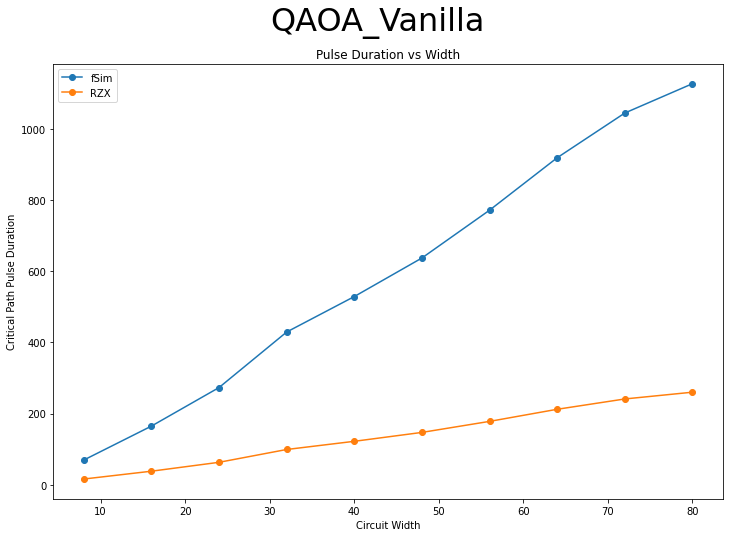

In [26]:
from backend_suite_v2 import decomp_backends
from circuit_suite import circuits
circuit_gen = circuits["QAOA_Vanilla"]
benchmark(backends=decomp_backends, circuit_generator=circuit_gen, continuously_save=True, overwrite=False)
plot(decomp_backends, circuit_gen.label, duration=True)
#edge_histogram(decomp_backends, circuit_gen.label)
#circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)

Transpiler qc24 for Modular-RR2-riswap
Transpiler qc24 for Modular-RR3-riswap
Transpiler qc32 for Modular-riswap
Transpiler qc32 for Modular-RR1-riswap
Transpiler qc32 for Modular-RR2-riswap
Transpiler qc32 for Modular-RR3-riswap
Transpiler qc40 for Modular-riswap
Transpiler qc40 for Modular-RR1-riswap
Transpiler qc40 for Modular-RR2-riswap
Transpiler qc40 for Modular-RR3-riswap
Transpiler qc48 for Modular-riswap
Transpiler qc48 for Modular-RR1-riswap
Transpiler qc48 for Modular-RR2-riswap
Transpiler qc48 for Modular-RR3-riswap
Transpiler qc56 for Modular-riswap
Transpiler qc56 for Modular-RR1-riswap
Transpiler qc56 for Modular-RR2-riswap
Transpiler qc56 for Modular-RR3-riswap
Transpiler qc64 for Modular-riswap
Transpiler qc64 for Modular-RR1-riswap
Transpiler qc64 for Modular-RR2-riswap
Transpiler qc64 for Modular-RR3-riswap
Transpiler qc72 for Modular-riswap
Transpiler qc72 for Modular-RR1-riswap
Transpiler qc72 for Modular-RR2-riswap
Transpiler qc72 for Modular-RR3-riswap
Transpiler

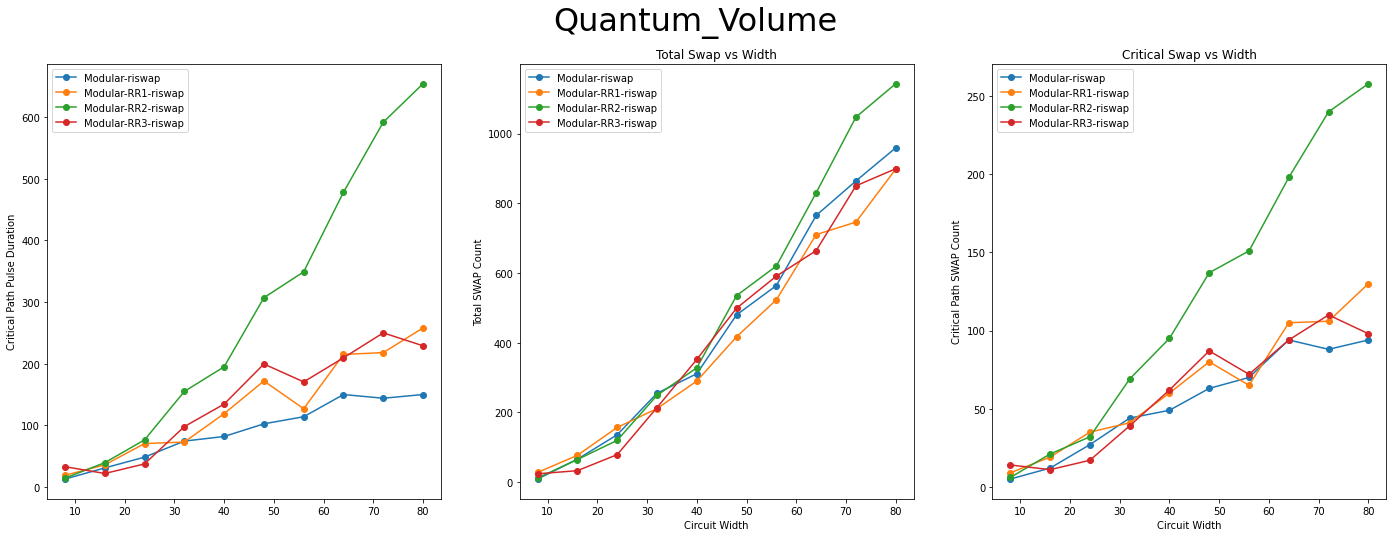

In [7]:
from backend_suite_v2 import modular_backends
from circuit_suite import circuits
circuit_gen = circuits["Quantum_Volume"]
benchmark(backends=modular_backends, circuit_generator=circuit_gen, continuously_save=True, overwrite=False)
plot(modular_backends, circuit_gen.label)
#edge_histogram(decomp_backends, circuit_gen.label)
#circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)

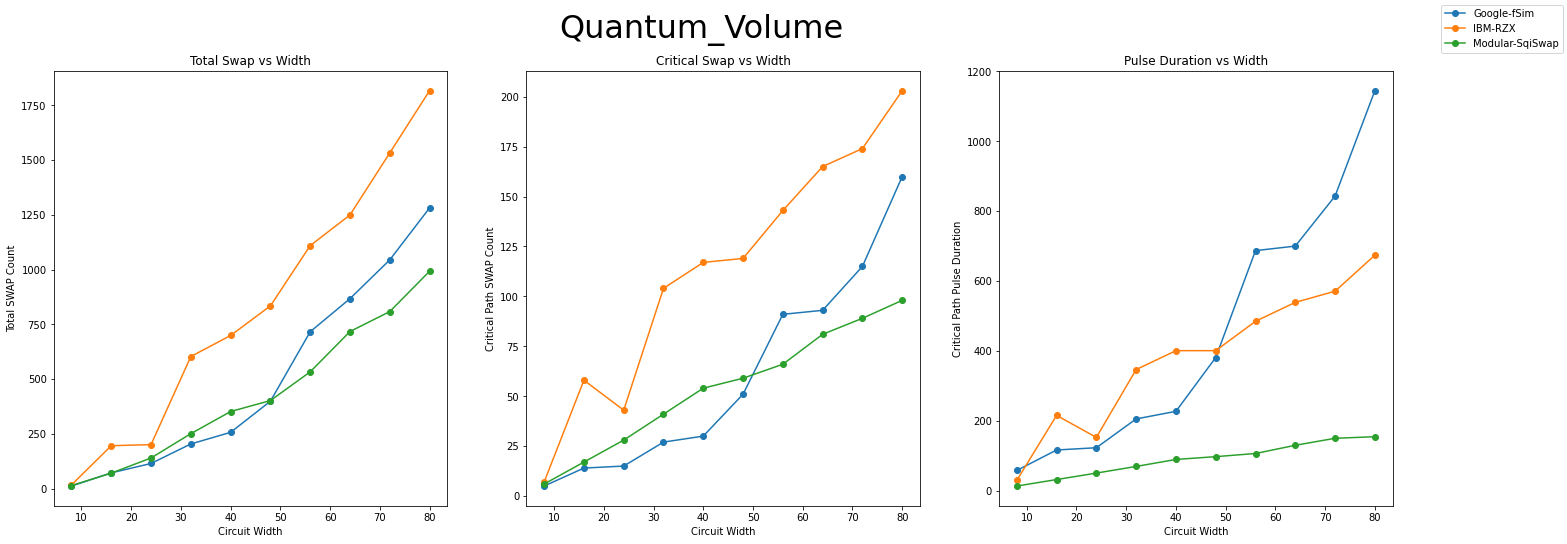

In [33]:
from backend_suite_v2 import industry_backends
from circuit_suite import circuits
circuit_gen = circuits["Quantum_Volume"]
benchmark(backends=industry_backends, circuit_generator=circuit_gen, continuously_save=True, overwrite=False)
plot(industry_backends, circuit_gen.label, duration=2)
#edge_histogram(decomp_backends, circuit_gen.label)
#circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)

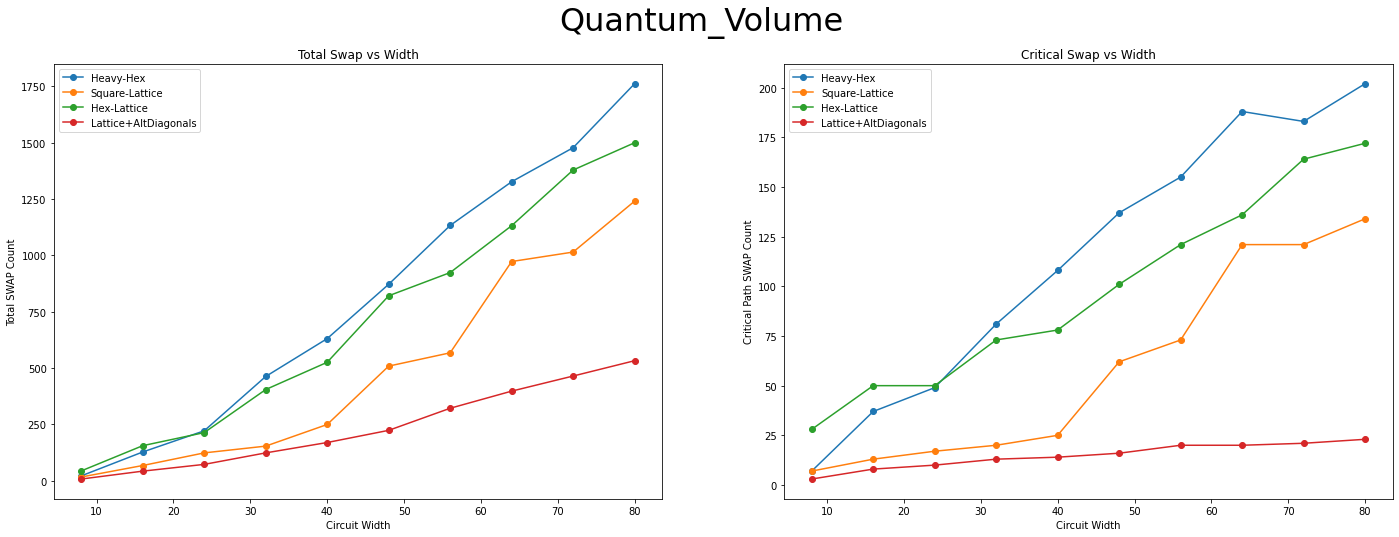

In [10]:
from backend_suite_v2 import motivation_backends
from circuit_suite import circuits
circuit_gen = circuits["Quantum_Volume"]
benchmark(backends=motivation_backends, circuit_generator=circuit_gen, continuously_save=True, overwrite=False)
plot(motivation_backends, circuit_gen.label, duration=False)
#edge_histogram(decomp_backends, circuit_gen.label)
#circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)

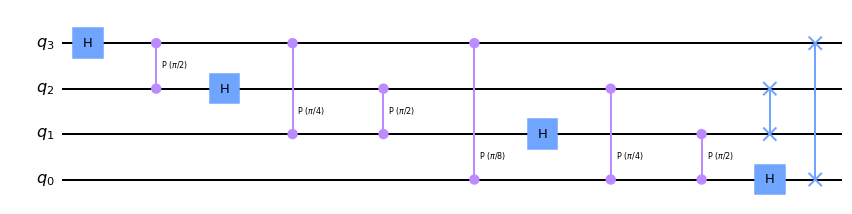

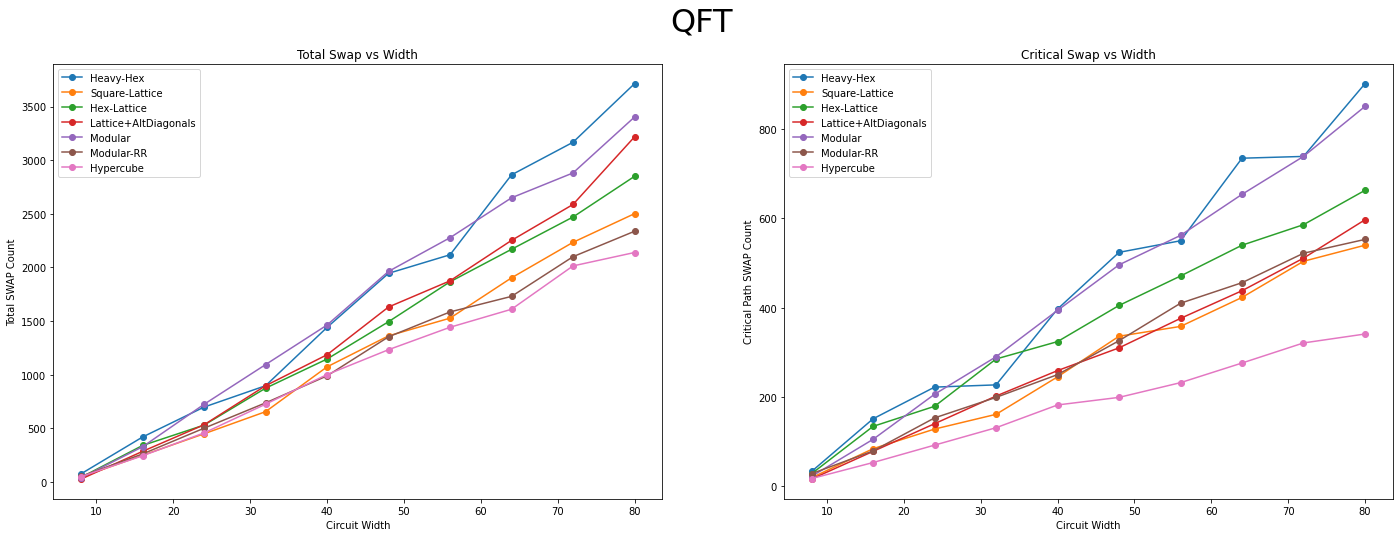

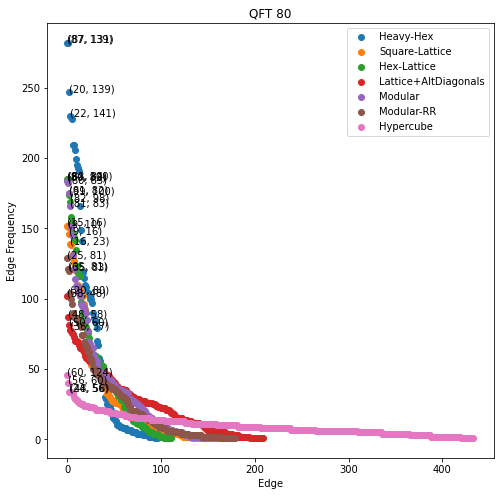

In [15]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits
circuit_gen = circuits["QFT"]
benchmark(backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True, overwrite=False)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)

Transpiler qc40 for Heavy-Hex
Transpiler qc40 for Square-Lattice
Transpiler qc40 for Hex-Lattice
Transpiler qc40 for Lattice+AltDiagonals
Transpiler qc40 for Modular
Transpiler qc40 for Modular-RR
Transpiler qc40 for Hypercube
Transpiler qc56 for Heavy-Hex
Transpiler qc56 for Square-Lattice
Transpiler qc56 for Hex-Lattice
Transpiler qc56 for Lattice+AltDiagonals
Transpiler qc56 for Modular
Transpiler qc56 for Modular-RR
Transpiler qc56 for Hypercube
Transpiler qc72 for Heavy-Hex
Transpiler qc72 for Square-Lattice
Transpiler qc72 for Hex-Lattice
Transpiler qc72 for Lattice+AltDiagonals
Transpiler qc72 for Modular
Transpiler qc72 for Modular-RR
Transpiler qc72 for Hypercube


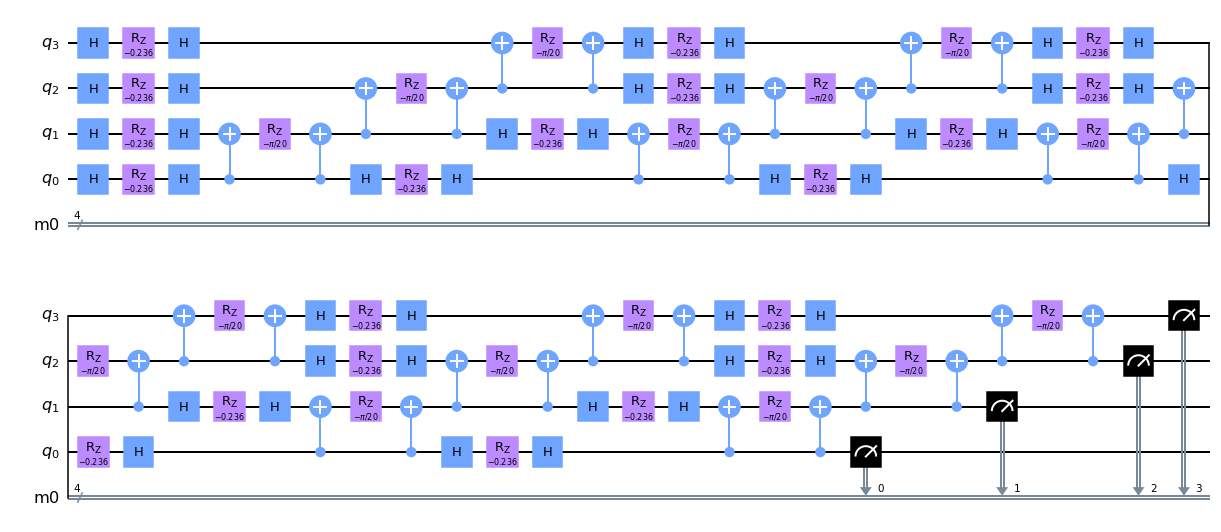

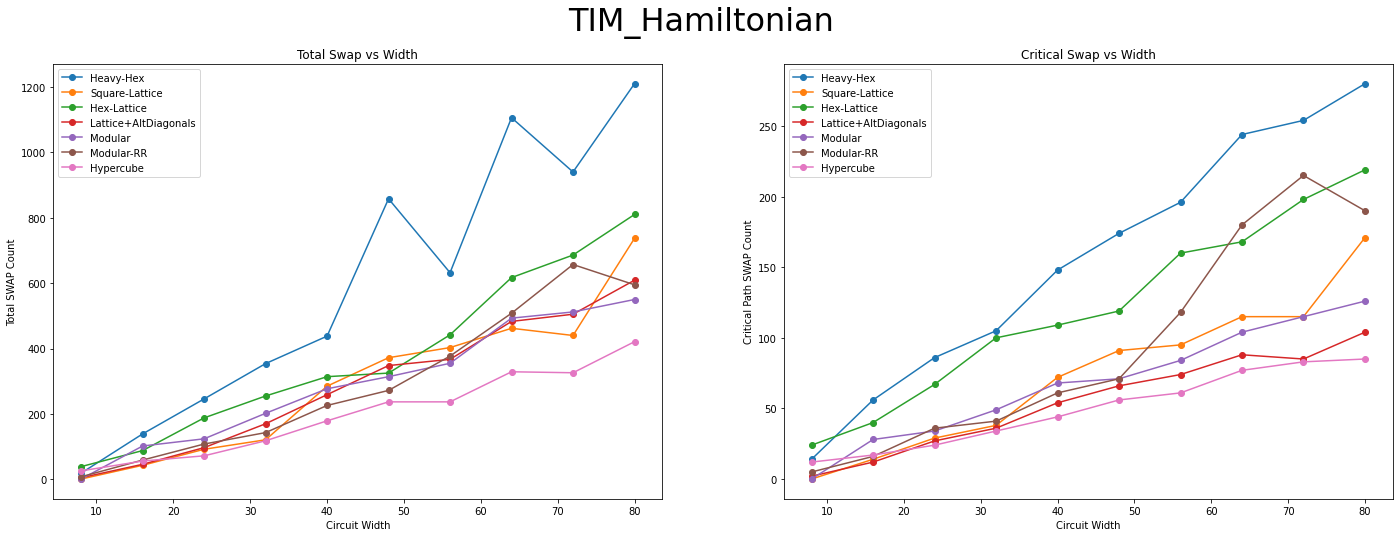

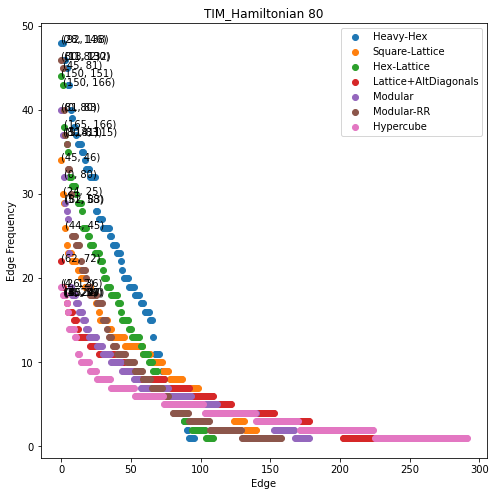

In [16]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits
circuit_gen = circuits["TIM_Hamiltonian"]
benchmark(backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).draw(output='mpl', reverse_bits=True)

Transpiler qc40 for Heavy-Hex
Transpiler qc40 for Square-Lattice
Transpiler qc40 for Hex-Lattice
Transpiler qc40 for Lattice+AltDiagonals
Transpiler qc40 for Modular
Transpiler qc40 for Modular-RR
Transpiler qc40 for Hypercube
Transpiler qc56 for Heavy-Hex
Transpiler qc56 for Square-Lattice
Transpiler qc56 for Hex-Lattice
Transpiler qc56 for Lattice+AltDiagonals
Transpiler qc56 for Modular
Transpiler qc56 for Modular-RR
Transpiler qc56 for Hypercube
Transpiler qc72 for Heavy-Hex
Transpiler qc72 for Square-Lattice
Transpiler qc72 for Hex-Lattice
Transpiler qc72 for Lattice+AltDiagonals
Transpiler qc72 for Modular
Transpiler qc72 for Modular-RR
Transpiler qc72 for Hypercube


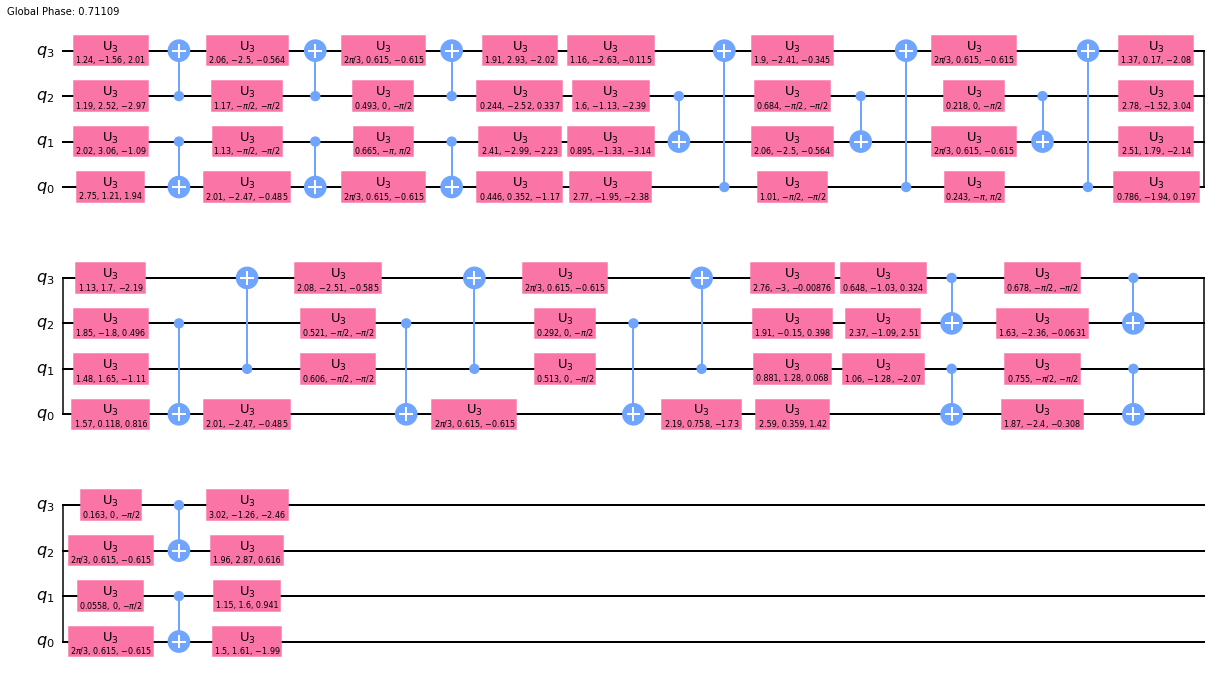

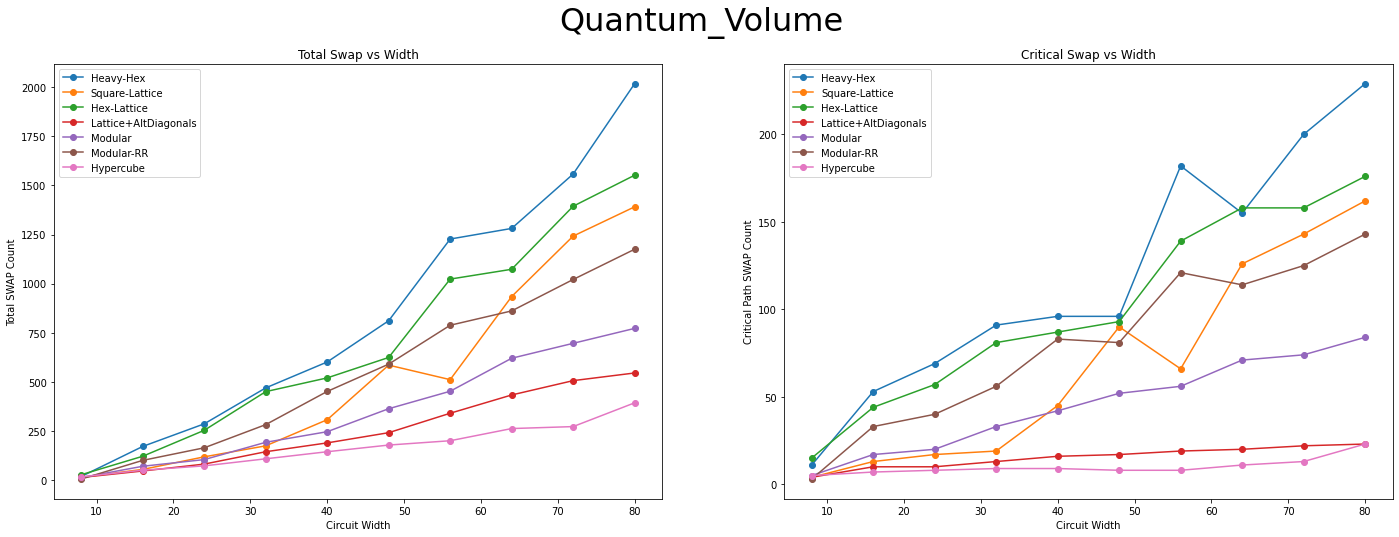

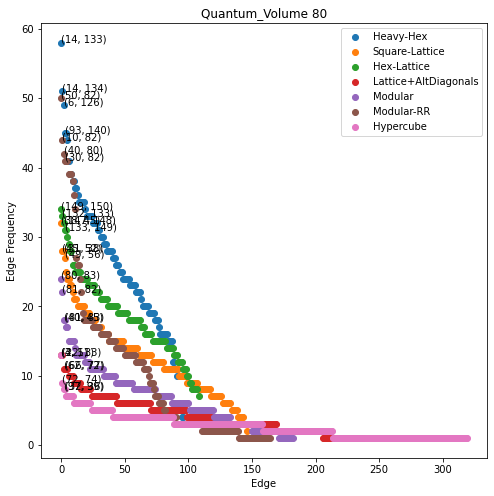

In [17]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits
circuit_gen = circuits["Quantum_Volume"]
benchmark(backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).decompose().decompose().draw(output='mpl', reverse_bits=True)

Transpiler qc40 for Heavy-Hex
Transpiler qc40 for Square-Lattice
Transpiler qc40 for Hex-Lattice
Transpiler qc40 for Lattice+AltDiagonals
Transpiler qc40 for Modular
Transpiler qc40 for Modular-RR
Transpiler qc40 for Hypercube
Transpiler qc56 for Heavy-Hex
Transpiler qc56 for Square-Lattice
Transpiler qc56 for Hex-Lattice
Transpiler qc56 for Lattice+AltDiagonals
Transpiler qc56 for Modular
Transpiler qc56 for Modular-RR
Transpiler qc56 for Hypercube
Transpiler qc72 for Heavy-Hex
Transpiler qc72 for Square-Lattice
Transpiler qc72 for Hex-Lattice
Transpiler qc72 for Lattice+AltDiagonals
Transpiler qc72 for Modular
Transpiler qc72 for Modular-RR
Transpiler qc72 for Hypercube


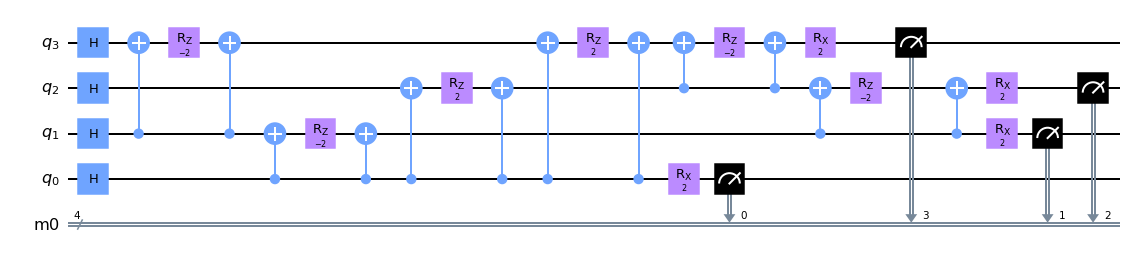

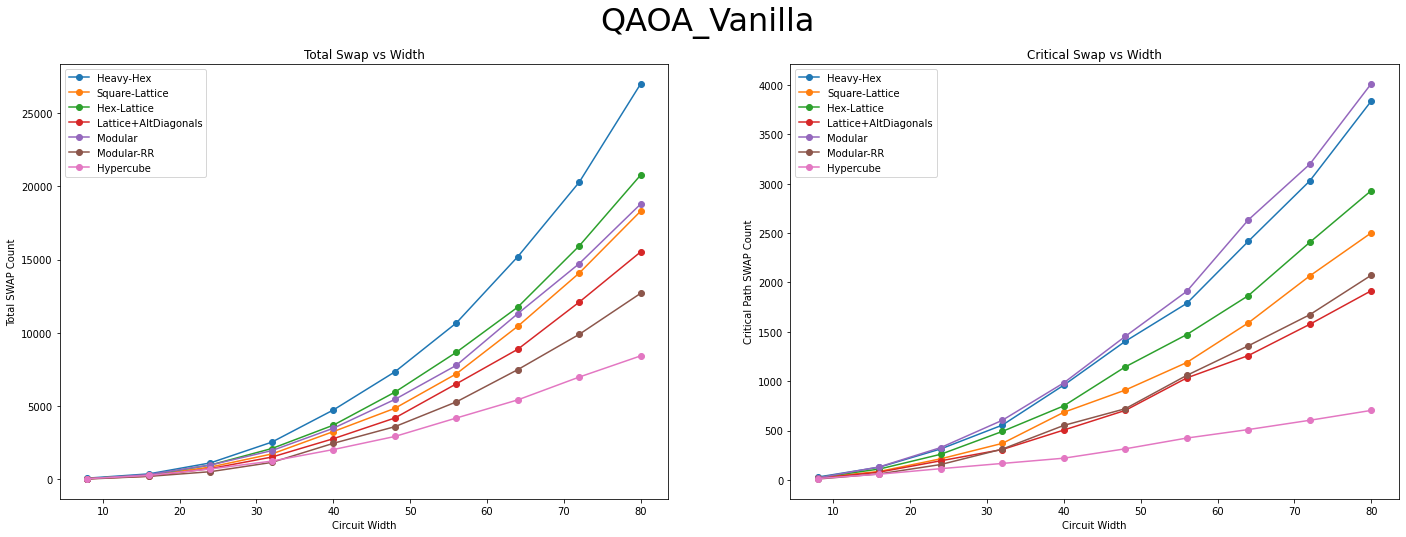

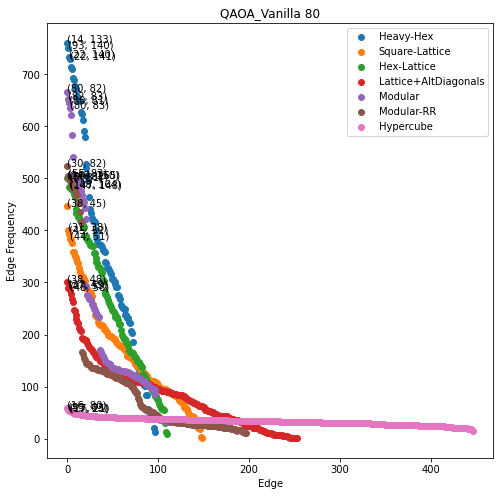

In [18]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits
circuit_gen = circuits["QAOA_Vanilla"]
benchmark(backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).draw(output='mpl', reverse_bits=True)

Transpiler qc40 for Heavy-Hex
Transpiler qc40 for Square-Lattice
Transpiler qc40 for Hex-Lattice
Transpiler qc40 for Lattice+AltDiagonals
Transpiler qc40 for Modular
Transpiler qc40 for Modular-RR
Transpiler qc40 for Hypercube
Transpiler qc56 for Heavy-Hex
Transpiler qc56 for Square-Lattice
Transpiler qc56 for Hex-Lattice
Transpiler qc56 for Lattice+AltDiagonals
Transpiler qc56 for Modular
Transpiler qc56 for Modular-RR
Transpiler qc56 for Hypercube
Transpiler qc72 for Heavy-Hex
Transpiler qc72 for Square-Lattice
Transpiler qc72 for Hex-Lattice
Transpiler qc72 for Lattice+AltDiagonals
Transpiler qc72 for Modular
Transpiler qc72 for Modular-RR
Transpiler qc72 for Hypercube


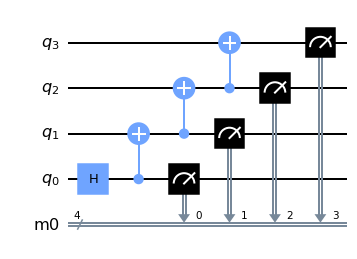

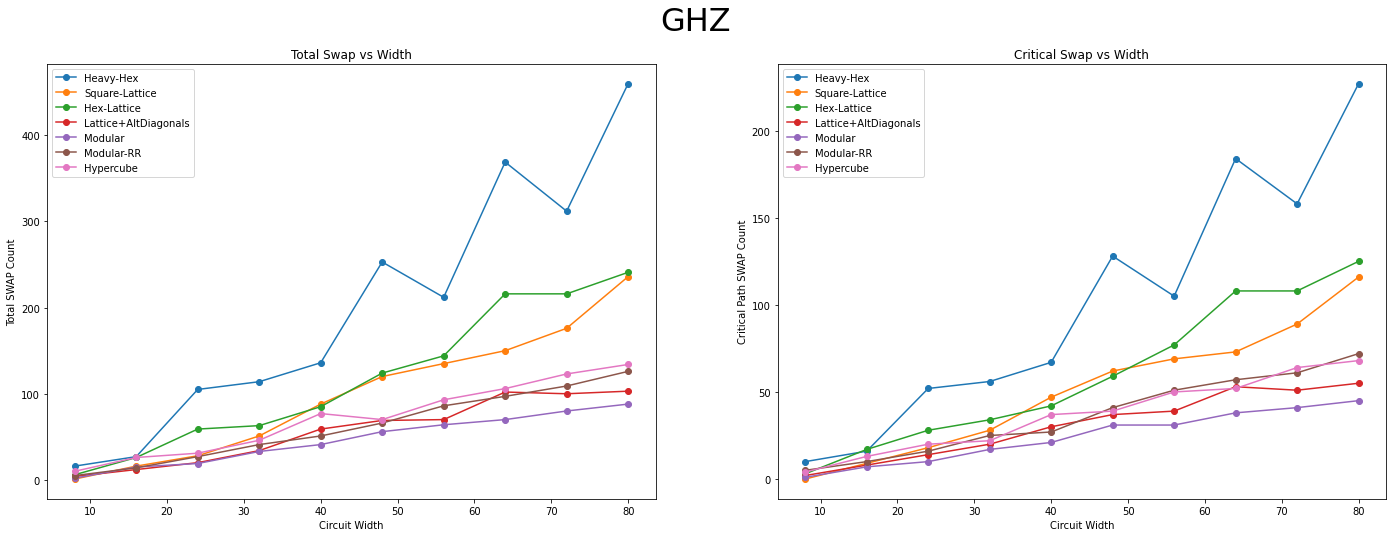

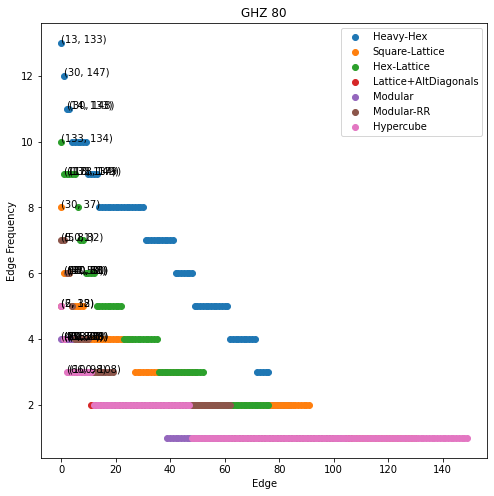

In [19]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits
circuit_gen = circuits["GHZ"]
benchmark(backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).draw(output='mpl', reverse_bits=True)

Transpiler qc40 for Heavy-Hex
Transpiler qc40 for Square-Lattice
Transpiler qc40 for Hex-Lattice
Transpiler qc40 for Lattice+AltDiagonals
Transpiler qc40 for Modular
Transpiler qc40 for Modular-RR
Transpiler qc40 for Hypercube
Transpiler qc56 for Heavy-Hex
Transpiler qc56 for Square-Lattice
Transpiler qc56 for Hex-Lattice
Transpiler qc56 for Lattice+AltDiagonals
Transpiler qc56 for Modular
Transpiler qc56 for Modular-RR
Transpiler qc56 for Hypercube
Transpiler qc72 for Heavy-Hex
Transpiler qc72 for Square-Lattice
Transpiler qc72 for Hex-Lattice
Transpiler qc72 for Lattice+AltDiagonals
Transpiler qc72 for Modular
Transpiler qc72 for Modular-RR
Transpiler qc72 for Hypercube


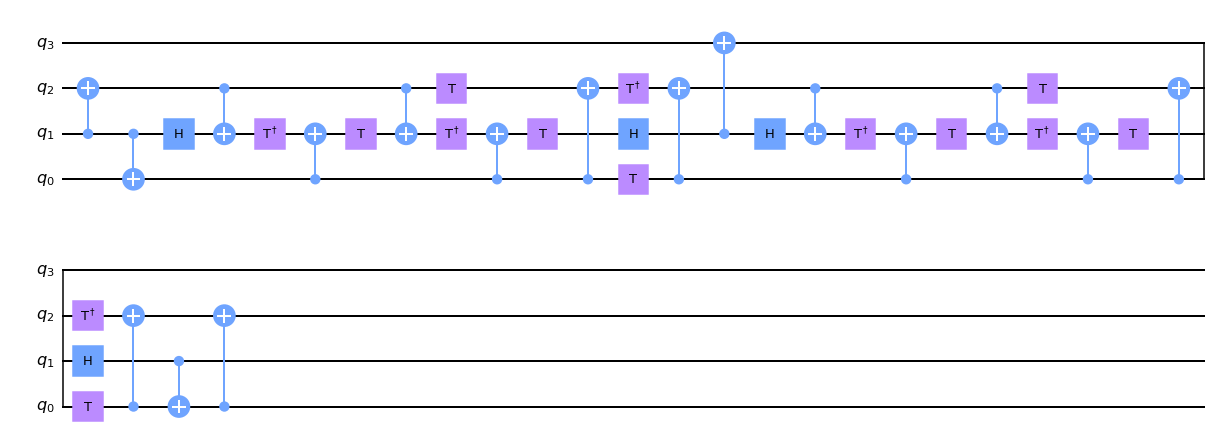

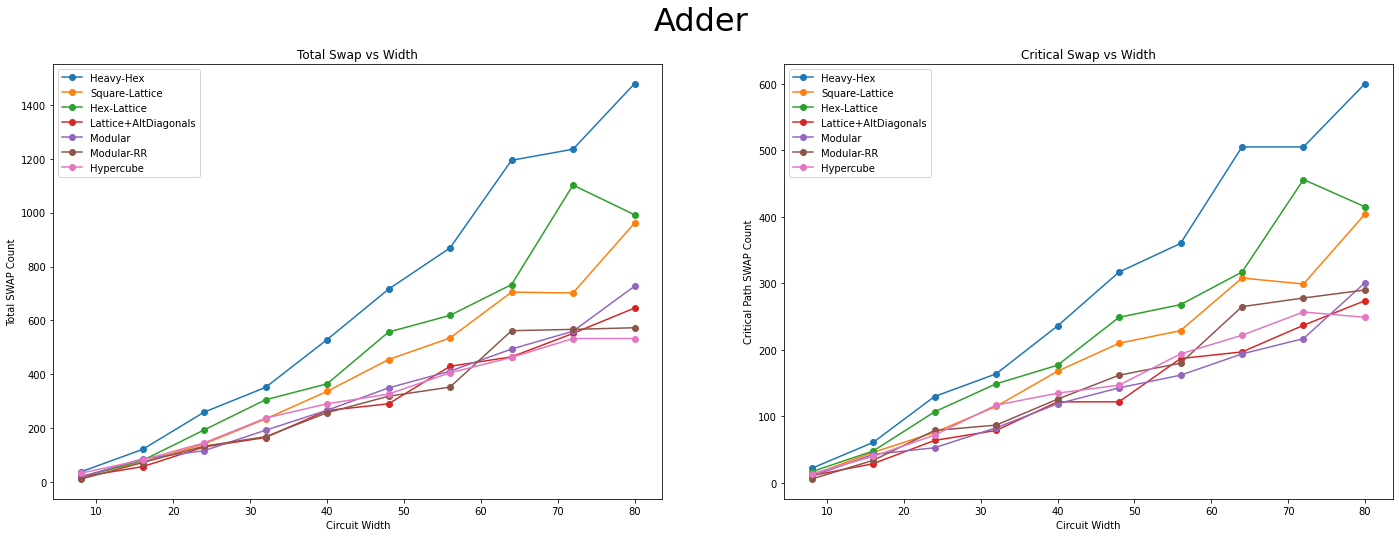

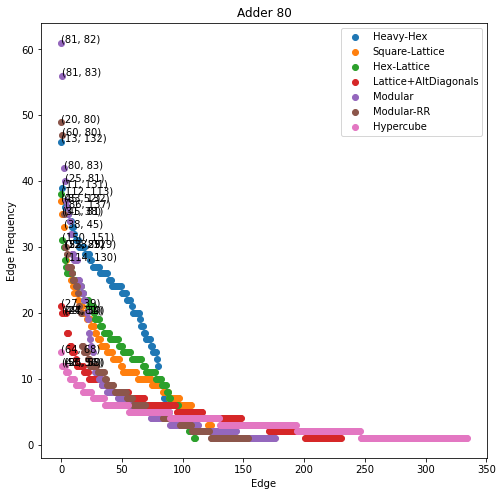

In [20]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits
circuit_gen = circuits["Adder"]
benchmark(backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).draw(output='mpl', reverse_bits=True)

Text(0.5, 0.98, 'Topology Parameters as predictors for transpilation success')

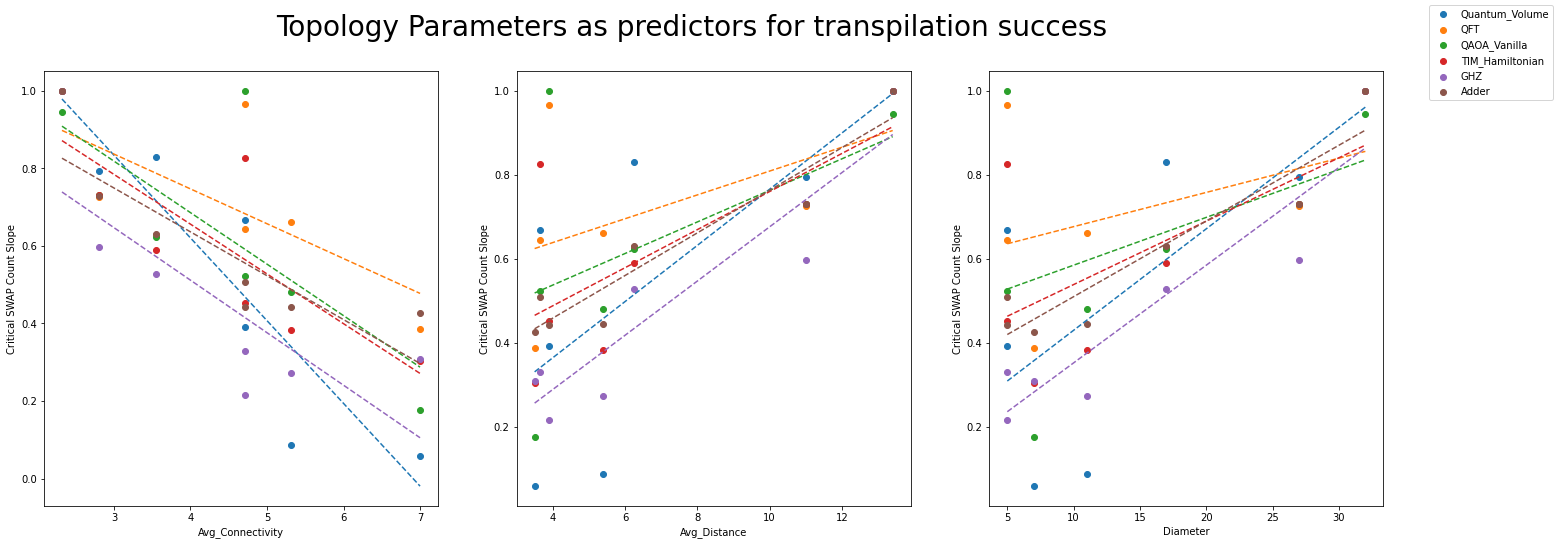

In [58]:
#try and do some data analysis
#requires backend_analysis_main.ipynb to be ran first
from matplotlib import pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,8))
from backend_suite_v2 import topology_backends
from circuit_suite import circuits

for circuit_label in circuits.keys():
#for circuit_label in ["GHZ"]:
    slope_list = []
    backend_property1 = []
    backend_property2 = []
    backend_property3 = []
    for backend in topology_backends:
        x = backend.data[circuit_label]["gate_count_crit"].keys()
        x = [int(el) for el in list(x)]
        y = backend.data[circuit_label]["gate_count_crit"].values()
        x, y = zip(*zip(x, y))
        y = [el['swap'] if 'swap' in el.keys() else 0 for el in y]
        x,y = zip(*sorted(zip(x,y)))
        from scipy.stats import linregress
        slope_list.append(linregress(x, y).slope)
        backend_property1.append(backend.data["Avg_Connectivity"]) #Diameter, Avg_Distance, Avg_Connectivity
        backend_property2.append(backend.data["Avg_Distance"])
        backend_property3.append(backend.data["Diameter"])
        # backend_property3.append(backend.data["Avg_Connectivity"]/backend.data["Avg_Distance"])

    #normalize slopes?
    slope_list = [el/max(slope_list) for el in slope_list]

    import numpy as np

    ax1.scatter(backend_property1, slope_list, label=circuit_label)
    x=backend_property1;y=slope_list
    ax1.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), '--')

    ax2.scatter(backend_property2, slope_list, label=circuit_label)
    x=backend_property2
    ax2.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), '--')

    ax3.scatter(backend_property3, slope_list, label=circuit_label)
    x=backend_property3
    ax3.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), '--')
    
ax1.set_xlabel("Avg_Connectivity")
ax2.set_xlabel("Avg_Distance")
ax3.set_xlabel("Diameter")
ax1.set_ylabel("Critical SWAP Count Slope")
ax2.set_ylabel("Critical SWAP Count Slope")
ax3.set_ylabel("Critical SWAP Count Slope")

handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels)
#ax2.legend()

fig.suptitle("Topology Parameters as predictors for transpilation success", size=28)

TODO: above data needs to be averaged, using better metric than linregress?, need r^2 values on lines

In [22]:
# from backend_suite_v2 import topology_backends
# from circuit_suite import circuits
# circuit_gen = circuits["Multiplier"]
# # circuit_gen.circuit_lambda(8).draw(output='mpl')
# #benchmark(backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True)
# plot(topology_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).draw(output='mpl', reverse_bits=True)

# Edge Contention Tests

In [23]:
# from backend_suite_v2 import dummy_backends
# from circuit_suite import circuits
# circuit_gen = circuits["QAOA_Vanilla"]
# benchmark(backends=dummy_backends, circuit_generator=circuit_gen, continuously_save=True, overwrite=False)
# plot(dummy_backends, circuit_gen.label)
# edge_histogram(dummy_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)